In [1]:
import numpy as np
import rebound
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from rebound.interruptible_pool import InterruptiblePool

$$ param: \qquad
r = \frac{j_2}{j_1},\qquad
\epsilon_1 = \mu_1 |C_1| e^{k_1},\qquad
\epsilon_2 = \mu_2 |C_2| e^{k_2}, \qquad
\nu = \frac{1}{\sqrt{3}}\frac{n_{r2}-n_{r1}}{n_{r1}} = \frac{1}{\sqrt{3}}\left(\frac{j_1(j_2+k_2)}{j_2(j_1-k_1)}\frac{n_2}{n_1}-1\right)$$

$$ ICs: \qquad
\phi = j_1(\lambda-n_{r1}t),\qquad 
p = -\sqrt{3}\left[\left(\frac{n_{r1}}{2\pi/P_0}\right)^{1/3}-1\right]$$

In [2]:
def param2OE(param, userDefined):
    r, nu, epsilon1, epsilon2 = param
    ecc, P1, j1, k1, k2 = userDefined
    
    j2 = r*j1
    
    #calculate C1 and C2
    coeff1 = (j1,-(j1-k1),0,-k1,0,0)
    C1 = df_coefficient_Ctilde(*coeff1,*(0,0,0,0))
    alpha1 = ((j1-k1)/j1)**(2/3)
    Cval1 = evaluate_df_coefficient_dict(C1,alpha1)

    coeff2 = (j2+k2,-j2,-k2,0,0,0)
    C2 = df_coefficient_Ctilde(*coeff2,*(0,0,0,0))
    alpha2 = (j2/(j2+k2))**(2/3)
    Cval2 = evaluate_df_coefficient_dict(C2,alpha2)

    # get mu1 and mu2
    mu1 = epsilon1 / (abs(Cval1) * ecc**k1)
    mu2 = epsilon2 / (abs(Cval2) * ecc**k2)
    
    # get P2
    P2 = P1 * j1*(j2+k2) / (j2*(j1-k1)*(np.sqrt(3)*nu + 1))

    return mu1, mu2, P1, P2

In [3]:
def OE2param(OE, userDefined):
    ecc, P1, P2, mu1, mu2 = OE
    j1, k1, j2, k2 = userDefined
    
    # get r
    r = j2/j1

    # calculate C1 and C2
    coeff1 = (j1,-(j1-k1),0,-k1,0,0)
    C1 = df_coefficient_Ctilde(*coeff1,*(0,0,0,0))
    alpha1 = ((j1-k1)/j1)**(2/3)
    Cval1 = evaluate_df_coefficient_dict(C1,alpha1)

    coeff2 = (j2+k2,-j2,-k2,0,0,0)
    C2 = df_coefficient_Ctilde(*coeff2,*(0,0,0,0))
    alpha2 = (j2/(j2+k2))**(2/3)
    Cval2 = evaluate_df_coefficient_dict(C2,alpha2)

    # get epsilon1 and epsilon2
    epsilon1 = mu1 * abs(Cval1) * ecc**k1
    epsilon2 = mu2 * abs(Cval2) * ecc**k2

    # get nu
    n1 = 2*np.pi/P1
    n_r1 = (j1-k1) * n1 / j1
    n2 = 2*np.pi/P2
    n_r2 = (j2+k2) * n2 / j2
    nu = 1/np.sqrt(3) * (n_r2/n_r1 - 1)
    
    return r, nu, epsilon1, epsilon2

In the paper, $\nu \in [-8,8]$ and $p \in [-4,4]$. If we scale them down by a factor of $s$, then
$$\epsilon_1 = \left(\frac{\nu}{\nu_0}\right)^2 = s^2, \qquad
\epsilon_2 = 0.1\left(\frac{\nu}{\nu_0}\right)^2 = 0.1s^2,$$

In [4]:
def simulation(param):
    s = 1/4000
    nu, p_0 = param
    ecc, P1, j1, k1, k2 = 0.070, 1, 5, 1, 1
    r, epsilon1, epsilon2 = 1, s**2, 0.1*s**2
    
    mu1, mu2, P1, P2 = param2OE((r, nu, epsilon1, epsilon2),(ecc, P1, j1, k1, k2))
    n_r1 = (j1-k1)*2*np.pi / (j1*P1)
    lambda_0, P_0 = j1*np.pi, (1-p_0/np.sqrt(3))**3 * (2*np.pi/n_r1)
    
    omega1, omega0, omega2 = -0.4, -0.86, 0
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=0.003, omega=omega1)
    sim.add(m=mu2, P=P2, e=0.016, omega=omega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc, omega=omega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    sim.init_megno()
    
    # calculate megno
    try:
        sim.integrate(1e5*2.*np.pi, exact_finish_time=0) # integrate for 1e4 orbitals, integrating to the nearest
        megno = sim.calculate_megno() 
        return megno
    except rebound.Collision:
        return 10.
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

In [5]:
Ngrid_x = 400
Ngrid_y = 400

s = 1/4000   # scaling factor on p and nu
nu = s*np.linspace(-8,8,Ngrid_x)
p_0 = s*np.linspace(-4,4,Ngrid_y)
parameters = [[x,y] for x in nu for y in p_0]

pool = InterruptiblePool()
results = pool.map(simulation,parameters)

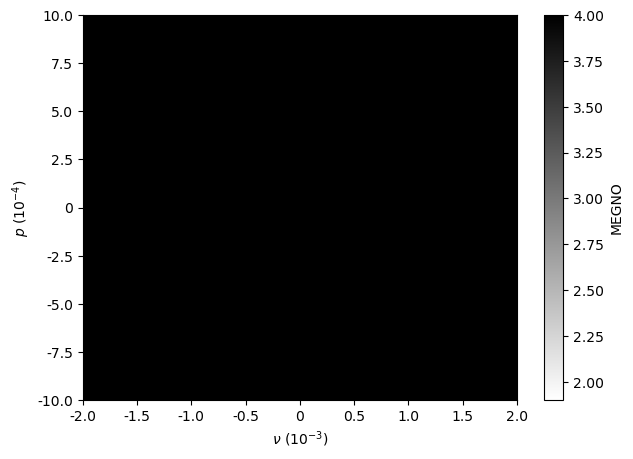

In [9]:
results2d = np.array(results).reshape(Ngrid_y,Ngrid_x)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(nu),max(nu),min(p_0),max(p_0)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel(r"$\nu$ ($10^{-3}$)")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel(r"$p$ ($10^{-4}$)")

ax.set_xticks(np.arange(-0.002, 0.0025, step=0.0005), ['-2.0','-1.5','-1.0','-0.5','0','0.5','1.0','1.5','2.0'])
ax.set_yticks(np.arange(-0.001, 0.00125, step=0.00025), ['-10.0','-7.5','-5.0','-2.5','0','2.5','5.0','7.5','10.0'])

im = ax.imshow(results2d.transpose(), interpolation="none", vmin=1.9, vmax=4, cmap="binary", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO")

plt.savefig('double surface of section.png')

To make the system more choatic, we increase $\epsilon_2$ by a factor of $8$.

In [ ]:
def simulation(param):
    s = 1/4000
    nu, p_0 = param
    ecc, P1, j1, k1, k2 = 0.07, 1, 5, 1, 1
    r, epsilon1, epsilon2 = 1, s**2, 0.8*s**2
    
    mu1, mu2, P1, P2 = param2OE((r, nu, epsilon1, epsilon2),(ecc, P1, j1, k1, k2))
    n_r1 = (j1-k1)*2*np.pi / (j1*P1)
    lambda_0, P_0 = j1*np.pi, (1-p_0/np.sqrt(3))**3 * (2*np.pi/n_r1)
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    omega1, omega0, omega2 = -0.4, -0.86, 0
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=0.003, omega=omega1)
    sim.add(m=mu2, P=P2, e=0.016, omega=omega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc, omega=omega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    sim.init_megno()
    
    # calculate megno
    try:
        sim.integrate(1e4*2.*np.pi, exact_finish_time=0)
        megno = sim.calculate_megno() 
        return megno
    except rebound.Collision:
        return 10.
    except rebound.Escape:
        return 10. # At least one particle got ejected, returning large MEGNO.

In [ ]:
Ngrid_x = 200
Ngrid_y = 200

s = 1/4000   # scaling factor on p and nu
nu = s*np.linspace(-8,8,Ngrid_x)
p_0 = s*np.linspace(-8,8,Ngrid_y)
parameters = [[x,y] for x in nu for y in p_0]

pool = InterruptiblePool()
results = pool.map(simulation,parameters)

In [ ]:
results2d = np.array(results).reshape(Ngrid_y,Ngrid_x)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(nu),max(nu),min(p_0),max(p_0)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel(r"$\nu$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel(r"$p$")
im = ax.imshow(results2d.transpose(), interpolation="none", vmin=1.9, vmax=4, cmap="binary", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO")